# Analyse du discours des Banques Centrales

In [1]:
import datetime
import copy as c
import random
import collections
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
#!pip install spacy
#!pip install spacy-langdetect
import spacy
from spacy.language import Language
from spacy_langdetect import LanguageDetector
#!python -m spacy download en_core_web_lg 

In [56]:
url="https://www.ecb.europa.eu/press/key/shared/data/all_ECB_speeches.csv?848ea64ce6d77827b5e8e18790878b64"
#df=pd.read_csv(url,sep = "|",encoding='utf-8')

# Une connexion lente peut obliger à télécharger le fichier en local
url_local=r"C:\Users\Antoine\Downloads\all_ECB_speeches.csv"
df=pd.read_csv(url_local,sep = "|",encoding='utf-8')

# fichier mis à jour tous les mois, dernière version : 1er décembre 2021 (47,8 Mo)
# à récupérer à l'adresse : https://www.ecb.europa.eu/press/key/html/downloads.en.html
# 2549 discours de responsables de la BCE entre 1997 et 2021

In [52]:
df

,date,speakers,title,subtitle,contents
0,2021-11-29,Christine Lagarde,Dialogue in a changing world,"Lectio Magistralis by Christine Lagarde, Presi...",SPEECH Dialogue in a changing world Lect...
1,2021-11-29,Isabel Schnabel,Inflation im Euroraum: Ursachen und Ausblick,"Presentation by Isabel Schnabel, Member of the...",NaN
2,2021-11-26,Christine Lagarde,Change and continuity in law,"Keynote speech by Christine Lagarde, President...",SPEECH Change and continuity in law Keyn...
3,2021-11-25,Frank Elderson,When you need change to preserve continuity: c...,"Speech by Frank Elderson, Member of the Execut...",SPEECH When you need change to preserve co...
4,2021-11-25,Isabel Schnabel,Inflation im Euroraum: Ursachen und Ausblick,"Presentation by Isabel Schnabel, Member of the...",NaN
...,...,...,...,...,...
2544,1997-05-13,Alexandre Lamfalussy,The European Central Bank: independent and acc...,Keynote speech delivered by Alexandre Lamfalus...,The European Central Bank: independent and a...
2545,1997-04-30,Alexandre Lamfalussy,The operation of monetary policy in stage thre...,"Address by Alexandre Lamfalussy, President of ...",The operation of monetary policy in stage th...
2546,1997-04-22,Alexandre Lamfalussy,Convergence and the role of the European Centr...,"Remarks by Alexandre Lamfalussy, President of ...",Convergence and the role of the European Cen...
2547,1997-03-10,Alexandre Lamfalussy,Securing the benefits of EMU,"Address by Alexandre Lamfalussy, President of ...",Securing the benefits of EMU Address by Al...


In [4]:
print(df.isna().sum())
# on affiche un dataframe avec toutes les lignes contenant au moins un NaN
df[df.isna().any(axis=1)] 

date         0
speakers     1
title        0
subtitle     1
contents    39
dtype: int64


,date,speakers,title,subtitle,contents
1,2021-11-29,Isabel Schnabel,Inflation im Euroraum: Ursachen und Ausblick,"Presentation by Isabel Schnabel, Member of the...",NaN
4,2021-11-25,Isabel Schnabel,Inflation im Euroraum: Ursachen und Ausblick,"Presentation by Isabel Schnabel, Member of the...",NaN
5,2021-11-24,Isabel Schnabel,A new strategy for a changing world,"Presentation by Isabel Schnabel, Member of the...",NaN
14,2021-11-11,Philip R. Lane,Expectations surveys: a tool for research and ...,"Introductory remarks by Philip R. Lane, Member...",NaN
17,2021-11-09,Fabio Panetta,Digital currencies around the world – what are...,"Presentation by Fabio Panetta, Member of the E...",NaN
31,2021-10-07,Philip R. Lane,Data analysis and monetary policy during the p...,"Presentation by Philip R. Lane, Member of the ...",NaN
41,2021-09-15,Philip R. Lane,The ECB's monetary policy strategy review - IM...,"Presentation by Philip R. Lane, Member of the ...",NaN
44,2021-08-26,Isabel Schnabel,Die neue geldpolitische Strategie der Europäis...,"Vortrag von Isabel Schnabel, Mitglied des Dire...",NaN
52,2021-06-24,Isabel Schnabel,The ECB’s policy response to the COVID-19 pand...,"Guest lecture by Isabel Schnabel, Member of th...",NaN
53,2021-06-22,Isabel Schnabel,Die Geldpolitik der EZB in der Corona-Krise,"Vortrag von Isabel Schnabel, Mitglied des Dire...",NaN


On remarque que pour tous les discours, on a seulement le titre et le speaker mais le contenu est NaN. Il faut donc mettre de côté tous ces discours sans contenu. Ce cas se présente seulement pour 39 discours (soit 1,5% de la base de données).

In [5]:
df=df.dropna(axis='index',how='any')
df=df.reset_index(drop=True)

In [6]:
df

,date,speakers,title,subtitle,contents
0,2021-11-29,Christine Lagarde,Dialogue in a changing world,"Lectio Magistralis by Christine Lagarde, Presi...",SPEECH Dialogue in a changing world Lect...
1,2021-11-26,Christine Lagarde,Change and continuity in law,"Keynote speech by Christine Lagarde, President...",SPEECH Change and continuity in law Keyn...
2,2021-11-25,Frank Elderson,When you need change to preserve continuity: c...,"Speech by Frank Elderson, Member of the Execut...",SPEECH When you need change to preserve co...
3,2021-11-24,Fabio Panetta,Patient monetary policy amid a rocky recovery,"Speech by Fabio Panetta, Member of the Executi...",SPEECH Patient monetary policy amid a rock...
4,2021-11-22,Luis de Guindos,Ralph Koijen’s contribution to research on the...,"Remarks by Luis de Guindos, Vice-President of ...",SPEECH Ralph Koijen’s contribution to rese...
...,...,...,...,...,...
2505,1997-05-13,Alexandre Lamfalussy,The European Central Bank: independent and acc...,Keynote speech delivered by Alexandre Lamfalus...,The European Central Bank: independent and a...
2506,1997-04-30,Alexandre Lamfalussy,The operation of monetary policy in stage thre...,"Address by Alexandre Lamfalussy, President of ...",The operation of monetary policy in stage th...
2507,1997-04-22,Alexandre Lamfalussy,Convergence and the role of the European Centr...,"Remarks by Alexandre Lamfalussy, President of ...",Convergence and the role of the European Cen...
2508,1997-03-10,Alexandre Lamfalussy,Securing the benefits of EMU,"Address by Alexandre Lamfalussy, President of ...",Securing the benefits of EMU Address by Al...


### En explorant le dataset, on se rend compte que certains contenus de discours sont vides (empty string mais pas NaN).
### Il faut donc retirer ces lignes du dataframe.

In [7]:
L=[]
for i in range(len(df)):
    if not bool(df["contents"][i].strip()): #si le contenu du discours est vide
        L.append(i)
L # ne concerne qu'une ligne

[2009]

In [8]:
df=df.drop(L).reset_index(drop=True)
df

,date,speakers,title,subtitle,contents
0,2021-11-29,Christine Lagarde,Dialogue in a changing world,"Lectio Magistralis by Christine Lagarde, Presi...",SPEECH Dialogue in a changing world Lect...
1,2021-11-26,Christine Lagarde,Change and continuity in law,"Keynote speech by Christine Lagarde, President...",SPEECH Change and continuity in law Keyn...
2,2021-11-25,Frank Elderson,When you need change to preserve continuity: c...,"Speech by Frank Elderson, Member of the Execut...",SPEECH When you need change to preserve co...
3,2021-11-24,Fabio Panetta,Patient monetary policy amid a rocky recovery,"Speech by Fabio Panetta, Member of the Executi...",SPEECH Patient monetary policy amid a rock...
4,2021-11-22,Luis de Guindos,Ralph Koijen’s contribution to research on the...,"Remarks by Luis de Guindos, Vice-President of ...",SPEECH Ralph Koijen’s contribution to rese...
...,...,...,...,...,...
2504,1997-05-13,Alexandre Lamfalussy,The European Central Bank: independent and acc...,Keynote speech delivered by Alexandre Lamfalus...,The European Central Bank: independent and a...
2505,1997-04-30,Alexandre Lamfalussy,The operation of monetary policy in stage thre...,"Address by Alexandre Lamfalussy, President of ...",The operation of monetary policy in stage th...
2506,1997-04-22,Alexandre Lamfalussy,Convergence and the role of the European Centr...,"Remarks by Alexandre Lamfalussy, President of ...",Convergence and the role of the European Cen...
2507,1997-03-10,Alexandre Lamfalussy,Securing the benefits of EMU,"Address by Alexandre Lamfalussy, President of ...",Securing the benefits of EMU Address by Al...


#### On se rend compte que certains discours ne sont pas en anglais.
#### Il faut donc les retirer.

Nombre moyen de caractères dans les discours :  19632.969310482265
Minimum de caractères dans les discours :  249
Maximum de caractères dans les discours :  113165


<AxesSubplot:title={'center':'Nombre de caractères dans les discours'}>

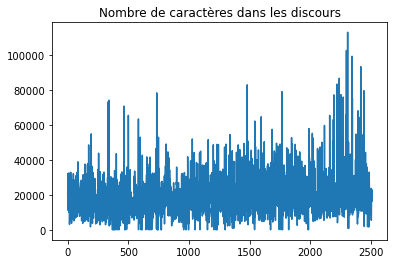

In [9]:
# Test sur la longueur du contenu des discours
print("Nombre moyen de caractères dans les discours : ",df.contents.str.len().mean())
print("Minimum de caractères dans les discours : ", df.contents.str.len().min())
print("Maximum de caractères dans les discours : ", df.contents.str.len().max())
df.contents.str.len().plot(title="Nombre de caractères dans les discours")

Nombre moyen de caractères dans les titres :  60.748903945795135
Minimum de caractères dans les titres :  5
Maximum de caractères dans les titres :  231


<AxesSubplot:title={'center':'Nombre de caractères dans les titres'}>

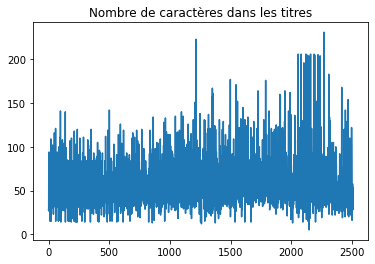

In [10]:
#Test sur la longueur des titres
print("Nombre moyen de caractères dans les titres : ",df.title.str.len().mean())
print("Minimum de caractères dans les titres : ", df.title.str.len().min())
print("Maximum de caractères dans les titres : ", df.title.str.len().max())
df.title.str.len().plot(title="Nombre de caractères dans les titres")

## Modèle de détection (spacy)

In [11]:

def get_lang_detector(nlp, name):
    return LanguageDetector()

nlp = spacy.load('en_core_web_lg')
#Language.factory("language_detector", func=get_lang_detector)
nlp.add_pipe('language_detector', last=True)
text = 'This is an english text.'
doc = nlp(text)
print(doc._.language)


{'language': 'en', 'score': 0.9999962398274698}


In [12]:
doc._.language["language"]

'en'

## Avec les titres 

In [13]:
start = time.time()
EN=0
OTHERS=0
L=[]
I0=[]
s=''
n=len(df)
#random.sample(range(n),500)
for i in range(n):
    #print(i)
    s=df["title"][i]
    doc = nlp(s)
    if doc._.language["language"]=='en':
        EN+=1
    else:
        OTHERS+=1
        L.append(s)
        I0.append(i)
print("Proportion de discours en anglais : ", EN/n)
end = time.time()
print("Temps pris par cette méthode :", end - start)

"""
Proportion de discours en anglais :  0.8999601434834595
Temps pris par cette méthode : 25.839558839797974
"""

Proportion de discours en anglais :  0.8983658828218414
Temps pris par cette méthode : 31.029661178588867


'\nProportion de discours en anglais :  0.8999601434834595\nTemps pris par cette méthode : 25.839558839797974\n'

## Avec les 1000 premiers caractères du discours

In [14]:
start = time.time()
EN=0
OTHERS=0
L=[]
I1=[]
s=''
n=len(df)
#random.sample(range(n),500)
for i in range(n):
    #print(i)
    s=df["contents"][i][:1000]
    doc = nlp(s)
    if doc._.language["language"]=='en':
        EN+=1
    else:
        OTHERS+=1
        L.append(s)
        I1.append(i)
print("Proportion de discours en anglais : ", EN/n)
end = time.time()
print("Temps pris par cette méthode :", end - start)

"""Proportion de discours en anglais :  0.9182941410920685
Temps pris par cette méthode : 80.60761404037476"""

Proportion de discours en anglais :  0.9174970107612594
Temps pris par cette méthode : 88.06156325340271


'Proportion de discours en anglais :  0.9182941410920685\nTemps pris par cette méthode : 80.60761404037476'

## Avec le début du discours privé de la répétition du titre

In [15]:
start = time.time()
EN=0
OTHERS=0
L=[]
I2=[]
s=''
n=len(df)
#random.sample(range(n),500)
for i in range(n):
    #print(i)
    s=df["contents"][i][200:2000]
    doc = nlp(s)
    if doc._.language["language"]=='en':
        EN+=1
    else:
        OTHERS+=1
        L.append(s)
        I2.append(i)
print("Proportion de discours en anglais : ", EN/n)
end = time.time()
print("Temps pris par cette méthode :", end - start)

"""Proportion de discours en anglais :  0.9286568353925867
Temps pris par cette méthode : 129.33490419387817"""

Proportion de discours en anglais :  0.9294539657233958
Temps pris par cette méthode : 127.71850490570068


'Proportion de discours en anglais :  0.9286568353925867\nTemps pris par cette méthode : 129.33490419387817'

## Avec les 2000 premiers caractères

In [16]:
start = time.time()
EN=0
OTHERS=0
L=[]
I3=[]
s=''
n=len(df)
#random.sample(range(n),500)
for i in range(n):
    #print(i)
    s=df["contents"][i][:2000]
    doc = nlp(s)
    if doc._.language["language"]=='en':
        EN+=1
    else:
        OTHERS+=1
        L.append(s)
        I3.append(i)
print("Proportion de discours en anglais : ", EN/n)
end = time.time()
print("Temps pris par cette méthode :", end - start)

"""Proportion de discours en anglais :  0.9290554005579912
Temps pris par cette méthode : 143.3227822780609"""

Proportion de discours en anglais :  0.9294539657233958
Temps pris par cette méthode : 133.69751930236816


'Proportion de discours en anglais :  0.9290554005579912\nTemps pris par cette méthode : 143.3227822780609'

# Modèle de détection langdetect

In [17]:
#!pip install langdetect
from langdetect import detect

In [1]:
# Extrait de la documentation https://pypi.org/project/langdetect/#description
# langdetect Language detection algorithm is non-deterministic,
# which means that if you try to run it on a text which is either too short or too ambiguous,
# you might get different results everytime you run it.
# To enforce consistent results, call following code before the first language detection:

from langdetect import DetectorFactory
DetectorFactory.seed = 0

In [18]:
start = time.time()
EN=0
OTHERS=0
L=[]
J0=[]
s=''
n=len(df)
#random.sample(range(n),500)
for i in range(n):
    #print(i)
    s=detect(df["title"][i])
    if s=='en':
        EN+=1
    else:
        OTHERS+=1
        L.append(s)
        J0.append(i)
print("Proportion de discours en anglais : ", EN/n)
end = time.time()
print(end - start) 

# Quelques centaines de discours dans d'autres langues (français, allemand, espagnol, italien, néerlandais,...)
# Cependant on constate qu'il reste des discours en français et en allemand non mis de coté
# Certains discours en anglais sont mis de côté de manière injustifiée

"""Proportion de discours en anglais :  0.9035472299721005
Temps pris par cette méthode : 12.753894805908203"""

Proportion de discours en anglais :  0.9015544041450777
12.358983755111694


'Proportion de discours en anglais :  0.9035472299721005\nTemps pris par cette méthode : 12.753894805908203'

In [19]:
start = time.time()
EN_1=0
OTHERS_1=0
M=[]
J1=[]
s=''
n=len(df)
#random.sample(range(n),500)
for i in range(n):
    #print(i)
    s=detect(df["contents"][i][:1000])
    if s=='en':
        EN_1+=1
    else:
        OTHERS_1+=1
        M.append(s)
        J1.append(i)
print("Proportion de discours en anglais : ", EN_1/n)
end = time.time()
print("Temps pris par cette méthode :", end - start) 

"""
Proportion de discours en anglais :  0.917098445595855
Temps pris par cette méthode : 13.944712400436401
"""

Proportion de discours en anglais :  0.917895575926664
Temps pris par cette méthode : 13.802093982696533


'\nProportion de discours en anglais :  0.917098445595855\nTemps pris par cette méthode : 13.944712400436401\n'

In [20]:
start = time.time()
EN_1=0
OTHERS_1=0
M=[]
J2=[]
s=''
n=len(df)
#random.sample(range(n),500)
for i in range(n):
    #print(i)
    s=detect(df["contents"][i][200:2000])
    if s=='en':
        EN_1+=1
    else:
        OTHERS_1+=1
        M.append(s)
        J2.append(i)
print("Proportion de discours en anglais : ", EN_1/n)
end = time.time()
print("Temps pris par cette méthode :", end - start) 

"""
Proportion de discours en anglais :  0.9278597050617776
Temps pris par cette méthode : 20.057332754135132
"""

Proportion de discours en anglais :  0.9298525308888003
Temps pris par cette méthode : 18.86558437347412


'\nProportion de discours en anglais :  0.9278597050617776\nTemps pris par cette méthode : 20.057332754135132\n'

In [35]:
start = time.time()
EN_1=0
OTHERS_1=0
M=[]
J3=[]
s=''
n=len(df)
#random.sample(range(n),500)
for i in range(n):
    #print(i)
    s=detect(df["contents"][i][:2000])
    if s=='en':
        EN_1+=1
    else:
        OTHERS_1+=1
        M.append(s)
        J3.append(i)
print("Proportion de discours en anglais : ", EN_1/n)
end = time.time()
print("Temps pris par cette méthode :", end - start) 

"""
Proportion de discours en anglais :  0.9294539657233958
Temps pris par cette méthode : 19.53878378868103
"""

Proportion de discours en anglais :  0.9294539657233958
Temps pris par cette méthode : 19.53878378868103


'\nProportion de discours en anglais :  0.936229573535273\nTemps pris par cette méthode : 43.480761766433716\n'

In [36]:
start = time.time()
EN_1=0
OTHERS_1=0
M=[]
J4=[]
s=''
n=len(df)
#random.sample(range(n),500)
for i in range(n):
    #print(i)
    s=detect(df["contents"][i][:5000])
    if s=='en':
        EN_1+=1
    else:
        OTHERS_1+=1
        M.append(s)
        J4.append(i)
print("Proportion de discours en anglais : ", EN_1/n)
end = time.time()
print("Temps pris par cette méthode :", end - start) 

"""
Proportion de discours en anglais :  0.936229573535273
Temps pris par cette méthode : 37.724875688552856
"""

Proportion de discours en anglais :  0.936229573535273
Temps pris par cette méthode : 37.724875688552856


'\nProportion de discours en anglais :  0.936229573535273\nTemps pris par cette méthode : 43.480761766433716\n'

## Comparaison des méthodes

In [37]:
liste=[I0,I1,I2,I3,J0,J1,J2,J3,J4]
for L in liste:
    print(len(L))

255
207
177
177
247
206
176
177
160


In [41]:
#Comparaison des deux méthodes analysant uniquement les titres 
print([value for value in J0 if value not in I0]) #vérification à la main : titre "trompeur" mais contenu en anglais (sauf 1)
print([value for value in I0 if value not in J0]) #vérification à la main : contenu en anglais
# Les deux méthodes de détection via les titres semblent semblables mais assez peu efficaces 

[192, 500, 811, 901, 1109, 1223, 1388]
[62, 139, 361, 607, 697, 1333, 1343, 1374, 1465, 1491, 1822, 1832, 1861, 1881, 1979]


On peut observer un problème avec les discours de Jean-Claude Trichet, president de l'ECB de 2003 à 2011, qui commence (et parfois termine ) toutes ses interventions en français, parfois en allemand.
Alors que tous les discours sont en anglais.

In [42]:
# Comparaison des résultats des méthodes analysant les 2000 premiers caractères privés des titres
print([value for value in J2 if value not in I2])
print([value for value in I2 if value not in J2]) 
# Tous ce discours contiennent des phrases en allemand et/ou en français.

[]
[1977]


In [43]:
#En prenant en compte ou non les débuts de discours
print([value for value in I2 if value not in I3]) # toujours le problème avec les discours de Jean Claude Trichet 
print([value for value in I3 if value not in I2]) #discours très court en allemand 1758


[1137, 1473]
[1758, 1902]


In [58]:
print([value for value in J2 if value not in J3]) 
print([value for value in J3 if value not in J2]) 

[1473]
[1179, 1758]


In [44]:
print([value for value in I3 if value not in J3]) 
print([value for value in J3 if value not in I3]) 

[1902, 1977]
[1137, 1179]


In [46]:
for i in [value for value in I3 if value not in J3]:
    print(df["speakers"][i]," - ",df["title"][i])

Lorenzo Bini Smaghi  -  Economic forecasting and monetary policy
Gertrude Tumpel-Gugerell  -  Monetary and Financial Policies in the New Integrated Union


In [59]:
for i in [value for value in J3 if value not in J4]:
    print(df["speakers"][i]," - ",df["title"][i])

José Manuel González-Páramo  -  De la crisis sub-prime a la crisis soberana: el papel del BCE
Mario Draghi  -  Continuity, consistency and credibility
Vítor Constâncio  -  Laudatio for Professor Kenneth Rogoff, recipient of the 2011 Deutsche Bank Prize in Financial Economics
Lorenzo Bini Smaghi  -  Private sector involvement: From (good) theory to (bad) practice
Jean-Claude Trichet  -  Taking stock on financial reform
Lorenzo Bini Smaghi  -  Reserve accumulation: the other side of the coin
Gertrude Tumpel-Gugerell  -  Globalisierung der Post-Trade Infrastrukturen
Jürgen Stark  -  Issues paper for the conference "The financial crisis and its consequences for the world economy"
Jürgen Stark  -  Growth and productivity of the financial sector: challenges for monetary policy
Lorenzo Bini Smaghi  -  Economic policies on the two sides of the Atlantic: (why) are they different?
Jürgen Stark  -  The Agenda for the Competitiveness of Europe's Economy and Financial System
Jean-Claude Trichet  - 

In [47]:
#Comparaison qui semble la plus intéressante entre les deux méthodes
print([value for value in I3 if value not in J2]) 
print([value for value in J2 if value not in I3]) 

[1758, 1902, 1977]
[1137, 1473]


In [57]:
#df["contents"][1758] #discours très court et en allemand

In [49]:
n=random.sample([value for value in I3 if value not in J3],1)[0]
df["contents"][n]

'  Economic forecasting and monetary policy   Speech by Lorenzo Bini SmaghiMember of the Executive Board of the European Central BankKeynote speechDIW 1925 – 2005 conferenceBerlin, 8 December 2005 Ladies and Gentlemen, I am delighted to speak at this conference today. The DIW is the largest and oldest economics institute in Germany and conducts research in many fields of economic analysis.  Speaking in a research institute, I feel stimulated to address a few analytical issues, raising questions rather than providing answers, and without necessarily limiting the reasoning to predefined frameworks.  The conduct of monetary policy faces challenges which are quite similar to those of economic forecasting, with some additional complications.  As Niels Bohr, a Nobel laureate in Physics, used to say: “making predictions is very difficult,  especially  about the future.” I would add: “not only about the future”.  Forecasting the direction in which the economy is going is essential for monetary

## Autre modèle de détection de langage ?

In [31]:
#Autre idée : supprimer "à la main" les discours passant à travers les mailles du filet
# utiliser les articles/prépositions les plus courants : le/la/de ou die/fur

 ## Conclusion vis-à-vis des différentes méthodes

Même si les méthodes de détection de langages ave les titres uniquement sont plus rapides, elles entrainent beaucoup d'erreurs (trop de faux positifs). La difficulté de la détection vient en grande partie des discours de Jean Claude Trichet qui comportent plusieurs langues dont l'anglais.

On peut considérer que les discours en plusieurs langues (comme ceux de Jean-Claude Trichet) ne sont pas gênants car ils sont majoritairement en anglais. Il faut juste penser à adapter les stopwords en conséquence.

Par ailleurs, on peut remarquer que les méthodes de langdetect sont beaucoup plus rapides que celles de spacy pour des résultats équivalents (voire identiques). La méthode qui paraît la plus efficace pour cette détection est celle qui utilise langdetect en analysant les 2000 premiers caractères de chaque discours.

## Modification du dataframe

In [32]:
#df["Language"]=pd.Series(dtype=str)
#On pourrait ajouter une colonne "language" pour une analyse ultérieure

In [33]:
# On va donc retirer ces discours des données à analyser
I=J3
df=df.drop(I).reset_index(drop=True)
df

NameError: name 'I' is not defined

In [ ]:
df.sample(5)

On crée trois colonnes pour le jour, le mois et l'année qu'on établit à partir de la date.

In [ ]:

df["Year"]=df.date.str[:4].astype(int)
df["Month"]=df.date.str[5:7].astype(int)
df["Day"]=df.date.str[8:].astype(int)


In [ ]:
week=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
months=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df["DayofWeek"]=pd.Series(dtype=int)
df["DayofWeek_str"]=pd.Series(dtype=str)
df["Month_str"]=pd.Series(dtype=str)
for i in range(len(df)):
    df["DayofWeek"][i]=int(datetime.date(df["Year"][i],df["Month"][i],df["Day"][i]).isoweekday())
    df["DayofWeek_str"][i]=week[int(datetime.date(df["Year"][i],df["Month"][i],df["Day"][i]).weekday())]
    df["Month_str"][i]=months[df["Month"][i]-1]

#.weekday() : from 0 to 6
#.isoweekday() : from 1 to 7

df["DayofWeek"]=df["DayofWeek"].astype(int)

In [ ]:
df

In [ ]:
df_year=df.groupby("Year").count()
df_year["date"].plot()

In [ ]:
df_month=df.groupby("Month").count()
df_month["date"].plot()

In [ ]:
df_day=df.groupby("Day").count()
df_day["date"].plot()

In [ ]:
df_day=df.groupby("DayofWeek").count()
df_day["date"].plot()

## Analyse préliminaire des données 

In [ ]:
df[["Year","Month","Day","DayofWeek"]].value_counts().plot()
# Graphique très laid mais qui permet de voir qu'il y a un nombre de jours non négligeable pour lesquels il y a eu plusieurs discours


In [ ]:
#df["DayofWeek"].value_counts().barplot()

plt.figure()

df["DayofWeek"].value_counts().plot(kind="bar")
plt.title("On what days of the week are ECB speeches delivered?")

In [ ]:
array=df["DayofWeek"].value_counts().to_numpy()
array

In [ ]:
plt.clf()
plt.figure()

df["Day"].value_counts().plot(kind="bar")
plt.title("Which day are ECB speeches delivered?")

In [ ]:
plt.clf()
plt.figure()

df["Month_str"].value_counts().plot(kind="bar")
plt.title("On which month are ECB speeches delivered?")

In [ ]:
plt.clf()
plt.figure()

df["Year"].value_counts().plot(kind="bar")
plt.title("ECB Speeches over the years")

In [ ]:
plt.clf()
plt.figure()

df["speakers"].value_counts()[:15].plot(kind="bar")

plt.title("Top 15 ECB Speakers")

In [ ]:
df["contents"][21]

## Début de l'analyse pour le NLP

In [ ]:
rawtext=''
L=random.sample(range(len(df)),15)
for i in L:
    rawtext+=df["title"][i]+df["contents"][i]
# On commence par analyser 15 discours choisis au hasard 

In [ ]:
rawtext

In [ ]:
# Reconnaissance des entités nommées
from spacy import displacy

nlp = spacy.load("en_core_web_lg")
doc = nlp(rawtext)
displacy.render(doc, style="ent", jupyter=True)

In [ ]:
#Il faut définir un liste de stopwords (c'est-à-dire de mots non significatifs) 
#En anglais 
#from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [ ]:

alphabet=set('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ') #type(alphabet)=set "ensemble"
stop_words= stop_words | alphabet # On fait une union d'ensembles pour retirer des nuages de mots les lettres isolées
#L'étape précédeente peut êtr évitée en spécifiant min_word_length=2 dans la fonction WordCloud
wordlist=['The','It','And','this','This','The','the','these','These','those','Those','In','&','one','He','She','he','she','it','\\displaystyle','\\mathbb','\\neg','per','th','also','would','de','la']
stop_words.update(wordlist) #on ajoute des mots aux 'stopwords'

In [ ]:
#Fonction qui permet d'obtenir une liste de mots en minuscules sans les stopwords

def str_to_wordlist(text):
    text2 = c.copy(text)
    text2 = text2.lower() # minuscules
    text2 = re.sub(r'\d+','',text2) # enlever les nombres
    text2 = re.findall(r'\w+', text2) # enlever la ponctuation
    text2 = [word for word in text2 if not word in stop_words and len(word)>2] # enlever les stopwords
    return(text2)

#text = str_to_wordlist(text)

In [ ]:
def freq_dict(text):
    res = {}
    for word in text:
        try:
            res[word] += 1
        except KeyError:
            res[word] = 1
    return(res)


#dictionary = freq_dict(rawtext)

In [ ]:
"Fonction pour récupérer les fréquences des mots d'un texte"

def freq_mots(text,stopwords):
    text = re.sub(r'==.*?==+', ' ', text)
    text = text.replace('\n', ' ')
    text=text.replace('\'',' ')
    text=re.sub(r'[^\w\s]',' ',text) #retire la ponctuation
    text = re.sub(r'\d+','',text) #retire les nombres
    text=text.replace('%',' ')
    text=text.replace('+',' ')
    text=text.replace('=',' ')
    text=text.replace('*',' ')
    text=text.replace('_',' ')
    text=text.replace('-',' ')
    T=[mot for mot in text.split() if mot not in list(stopwords)]
    return collections.Counter(T)


In [ ]:
freq_mots(rawtext,stop_words)

In [ ]:
"Fonction pour récupérer la liste des mots d'un texte brut"
def liste_mots(text,stopwords):
    text = re.sub(r'==.*?==+', ' ', text)
    text = text.replace('\n', ' ')
    text=text.replace('\'',' ')
    text=re.sub(r'[^\w\s]',' ',text) #retire la ponctuation
    text = re.sub(r'\d+',' ',text) #retire les nombres
    text=text.replace('%',' ')
    text=text.replace('+',' ')
    text=text.replace('=',' ')
    text=text.replace('*',' ')
    text=text.replace('_',' ')
    text=text.replace('-',' ')
    return [mot for mot in text.split() if mot not in list(stopwords)]

In [ ]:
liste_mots(rawtext,stop_words)

In [ ]:
"Fonction pour récupérer les n mots les plus fréquents (hors stopwords) dans un texte brut"
def plus_frequents(text,n,stopwords):
    L=[]
    text = re.sub(r'==.*?==+', ' ', text)
    text = text.replace('\n', ' ')
    text=text.replace('\'',' ')
    text=re.sub(r'[^\w\s]',' ',text) #retire la ponctuation
    text = re.sub(r'\d+',' ',text) #retire les nombres
    text=text.replace('%',' ')
    text=text.replace('+',' ')
    text=text.replace('=',' ')
    text=text.replace('*',' ')
    text=text.replace('_',' ')
    text=text.replace('-',' ')
    T=[mot for mot in text.split() if mot not in list(stopwords)]
    for tuple in collections.Counter(T).most_common(n):
        L.append([tuple[0],tuple[1]])
    return L

In [ ]:
n=20
plus_frequents(rawtext,n,stop_words)

In [ ]:
rawtext=''
L=random.sample(range(len(df)),50)
for i in L:
    rawtext+=df["title"][i]+df["contents"][i]
# On commence par analyser 15 discours choisis au hasard 

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

#tokenizer.tokenize('Eighty-seven miles to go, yet.  Onward!')

#example_sent = "This is a sample sentence,showing off the stop words filtration."

def tokens_filter(text,stop_words):
    word_tokens = tokenizer.tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words] #retire les stopwords
    return filtered_sentence

text=tokens_filter(rawtext,stop_words)

In [ ]:
collections.Counter(text).most_common(20)

## les n-grams

In [ ]:
nltk.download('genesis')
nltk.corpus.genesis.words('english-web.txt')

In [ ]:
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()

## Bigrams
finder = BigramCollocationFinder.from_words(
   text)
# only bigrams that appear 3+ times
finder.apply_freq_filter(3)


# return the 10 n-grams with the highest PMI
# print (finder.nbest(bigram_measures.likelihood_ratio, 10))

for i in finder.score_ngrams(bigram_measures.likelihood_ratio):
    print (i)

In [ ]:
## Trigrams
trigram_measures = nltk.collocations.TrigramAssocMeasures()


finder = TrigramCollocationFinder.from_words(
   text)
# only trigrams that appear 3+ times
finder.apply_freq_filter(3)


# return the 10 n-grams with the highest PMI
# print (finder.nbest(trigram_measures.likelihood_ratio, 10))
for i in finder.score_ngrams(trigram_measures.likelihood_ratio):
    print (i)

In [ ]:
#Lemmatizer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
 
lemmatizer = WordNetLemmatizer()
 
print("rocks :", lemmatizer.lemmatize("rocks"))
print("corpora :", lemmatizer.lemmatize("corpora"))
 
# a denotes adjective in "pos"
print("better :", lemmatizer.lemmatize("better", pos ="a"))


In [ ]:
lemmatizer.lemmatize("thieves")

In [ ]:
#Most frequent words by year
years=df["Year"].unique()

def year_speeches(df,year):
    #df : pandas dataframe
    #year : int
    text=''
    df_year=df[df["Year"] == year].reset_index(drop=True)
    for i in range(len(df_year)):
        text+=df_year["title"][i]+df_year["contents"][i]
    return text



In [ ]:
year=2010
year_speeches(df,year)

In [ ]:
def freq_words_year(df,year,n=10):
    #df : pandas dataframe
    #year : int
    #n : int
    text=year_speeches(df,year)
    return collections.Counter(tokens_filter(text,stop_words)).most_common(n)

In [ ]:
year=2008
df_year=df[df["Year"] == year].reset_index(drop=True)
df_year

In [ ]:
df_year["contents"][0]

In [ ]:
year=2005
L=freq_words_year(df,year,20)
x=[]
y=[]
z=[]
for i in range(len(L)):
    x.append(L[i][0])
    y.append(L[i][1])
    z.append(round(100*L[i][1]/L[0][1],1))


In [ ]:
plt.clf()
fig, ax = plt.subplots(figsize=(8, 8))
plt.bar(x,y)

In [ ]:
freq_words_year(df,2005,20)

In [ ]:
# https://spacytextblob.netlify.app/docs/